In [1]:
import os, matplotlib.pyplot as plt, numpy as np, pandas as pd
import seaborn as sns#; sns.set()
from glob import glob
from datetime import datetime
from common_functions import load_data

In [2]:
# Load data
nn = 1 # how many neighbour positions to take into account
dt_shift = 10 # expected shift between center of the pore and motor protein in bases
features = ["si", "tr", "dt0", "dt%s"%dt_shift]

guppy_ver = "3.0.3.hac" #"4.0.15.hac"# 
fasta = "cc_yeast_rrna.fa" # reference FastA
fnpat = "guppy%s/RNA814001_*/workspace/*.bam"%guppy_ver # pattern for all BAM files

# load data from first KO experiment
regions = [("25s", 2129, "snR3"), ("25s", 2133, "snR3"), ("25s", 2264, "snR3"), ("25s", 2826, "snR34"), ("25s", 2880, "snR34"), ("18s", 1187, "snR36"), 
           ('25s', 1133, 'snR61'), ('25s', 1437, ''), ('25s', 1888, 'snR62'), ('25s', 817, 'snR60'), ('25s', 867, ''), ('25s', 908, 'snR60'), 
          ]
chr_pos2mt = {"%s_%s"%(chrom, pos) for chrom, pos, mt in regions}
chr_pos = ['18s_1187', '25s_1004', '25s_2129', '25s_2133', '25s_2264', '25s_2826', '25s_2880', '25s_986']
regions = [(cp.split("_")[0], int(cp.split("_")[-1]), "_") for cp in chr_pos]; regions
bams = sorted(glob(fnpat))
samples = [fn.split(os.path.sep)[-3].split("_")[-1] for fn in bams]; print(samples, regions)
region2data = load_data(fasta, bams, regions, features, nn=nn)

# load data from second KO experiment
fnpat2 = "guppy%s/RNA345944_*/workspace/*.bam"%guppy_ver
chr_pos2 = ['25s_1133', '25s_1437', '25s_1888', '25s_817', '25s_867', '25s_908']
regions2 = [(cp.split("_")[0], int(cp.split("_")[-1]), "_") for cp in chr_pos2]; regions2
bams2 = sorted(glob(fnpat2))
samples = [fn.split(os.path.sep)[-3].split("_")[-1] for fn in bams2]; print(samples, regions2)
region2data.update(load_data(fasta, bams2, regions2, features, nn=nn))

# define features
feature_names = ["%s_%s"%(f.upper(), i) for f in features for i in range(-nn, nn+1)]
len(feature_names), len(region2data)

['snR3', 'snR34', 'snR36', 'wt'] [('18s', 1187, '_'), ('25s', 1004, '_'), ('25s', 2129, '_'), ('25s', 2133, '_'), ('25s', 2264, '_'), ('25s', 2826, '_'), ('25s', 2880, '_'), ('25s', 986, '_')]


['snR60', 'snR61', 'snR62', 'wt'] [('25s', 1133, '_'), ('25s', 1437, '_'), ('25s', 1888, '_'), ('25s', 817, '_'), ('25s', 867, '_'), ('25s', 908, '_')]


(12, 14)

18s_1187
25s_1004
25s_2129
25s_2133
25s_2264
25s_2826
25s_2880
25s_986
25s_1133
25s_1437
25s_1888
25s_817
25s_867
25s_908


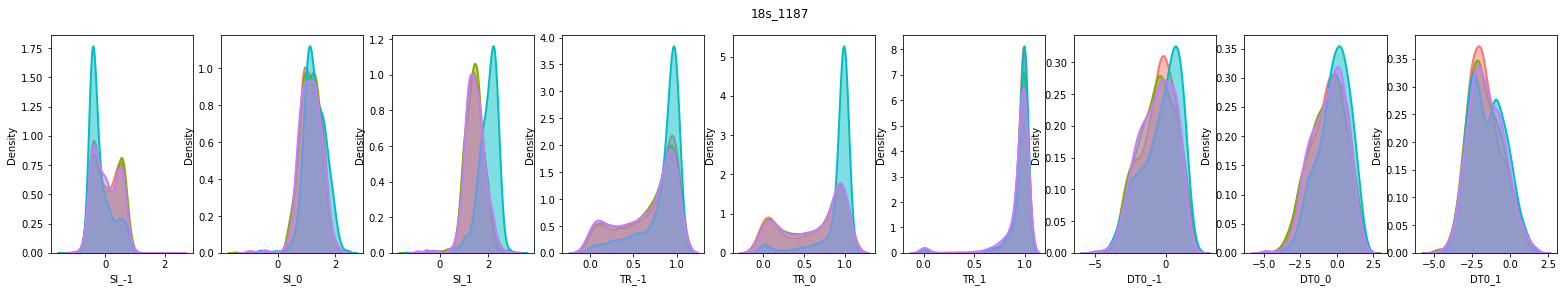

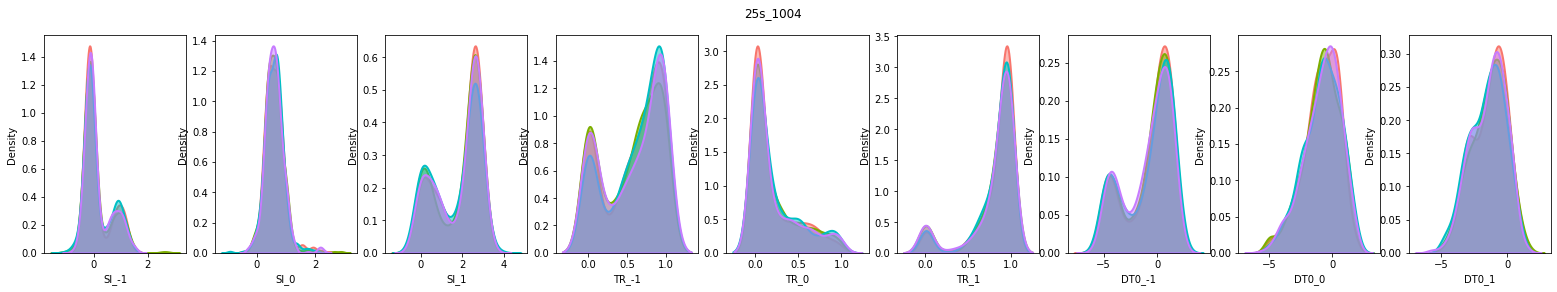

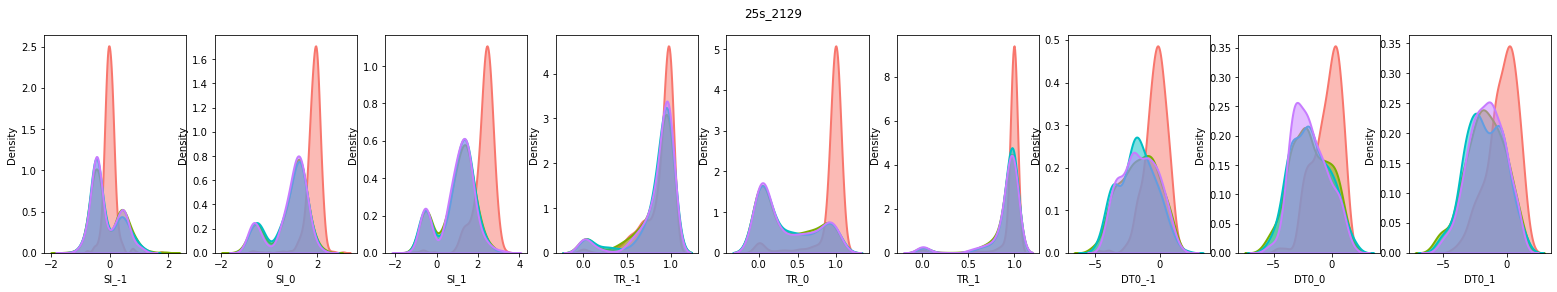

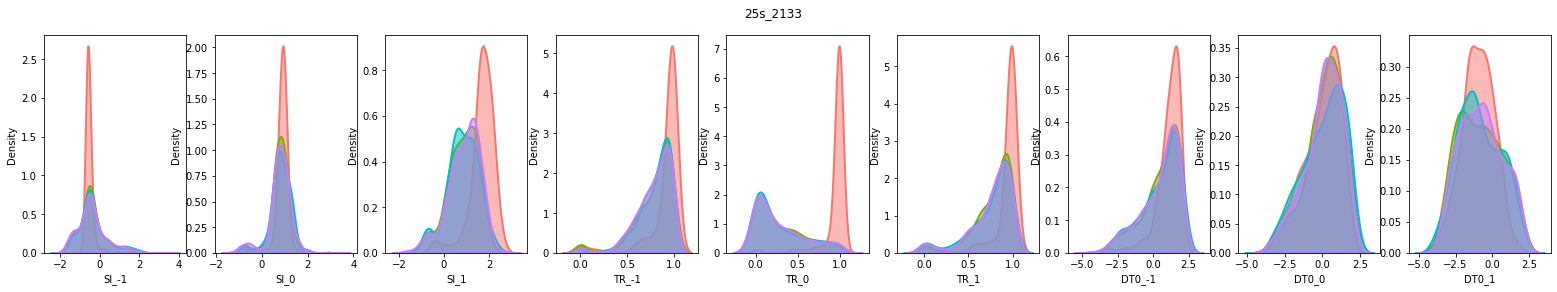

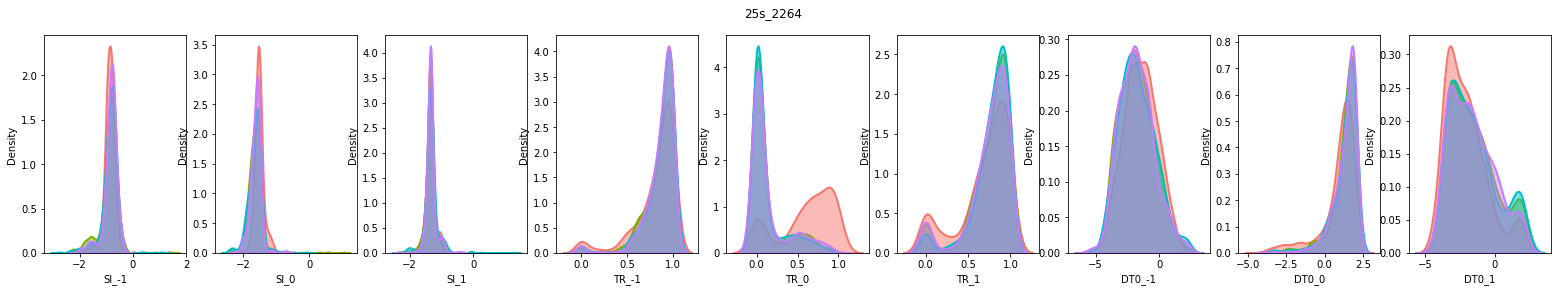

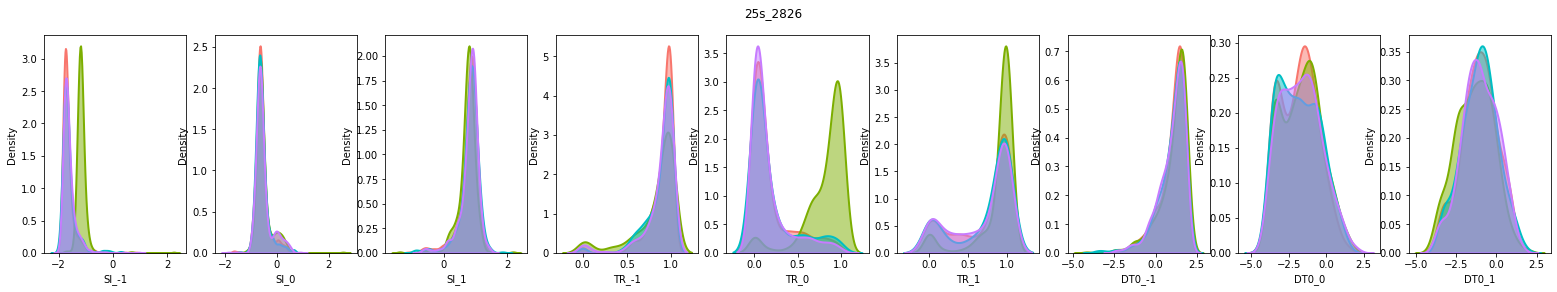

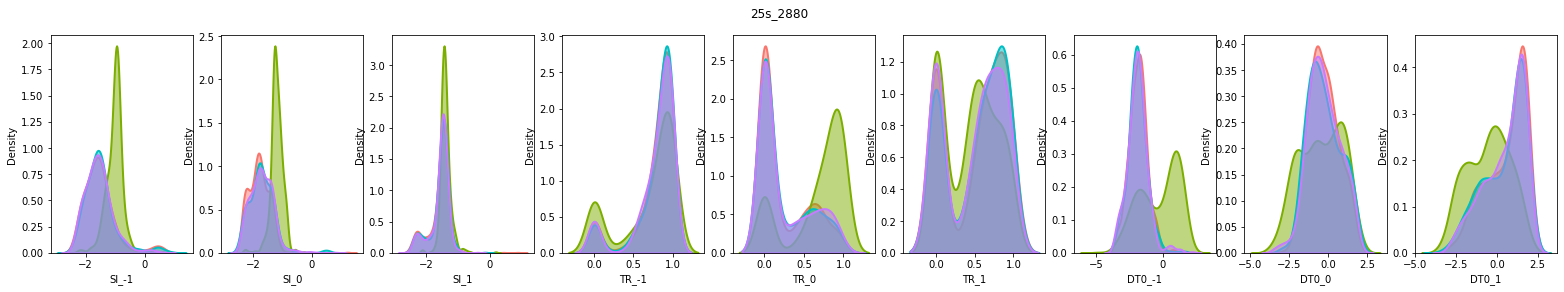

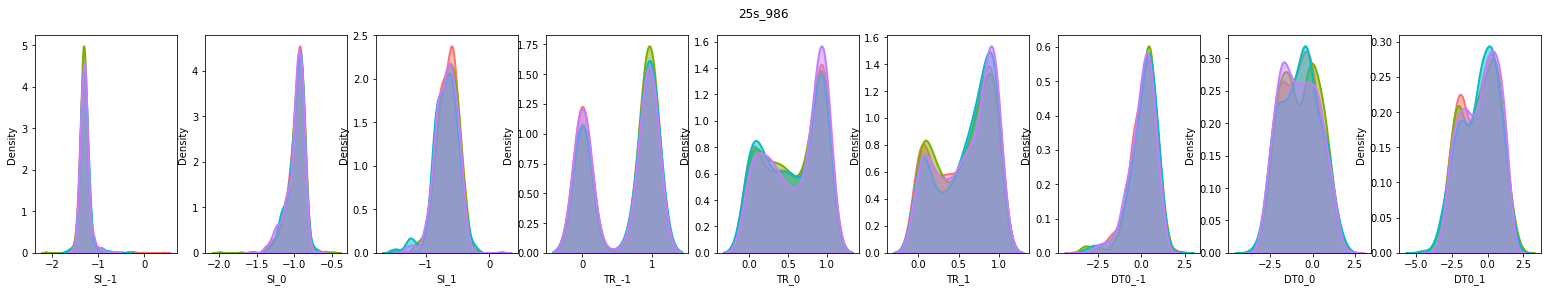

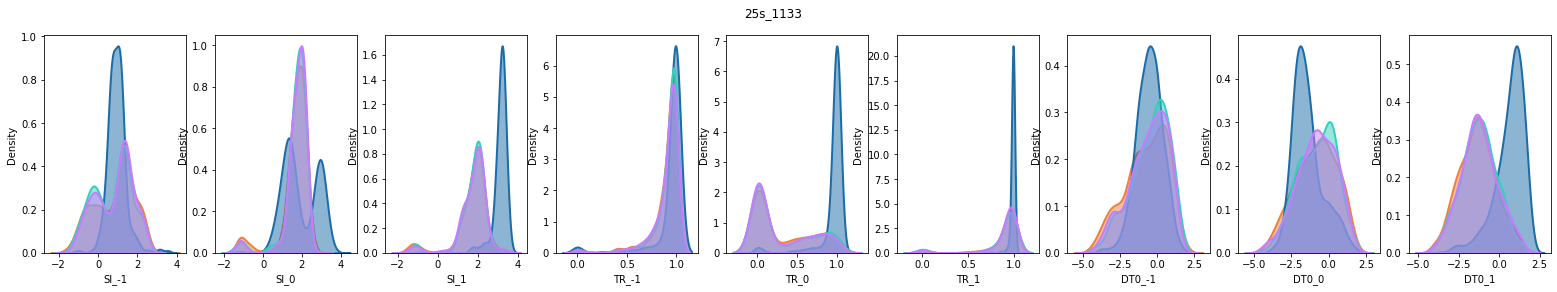

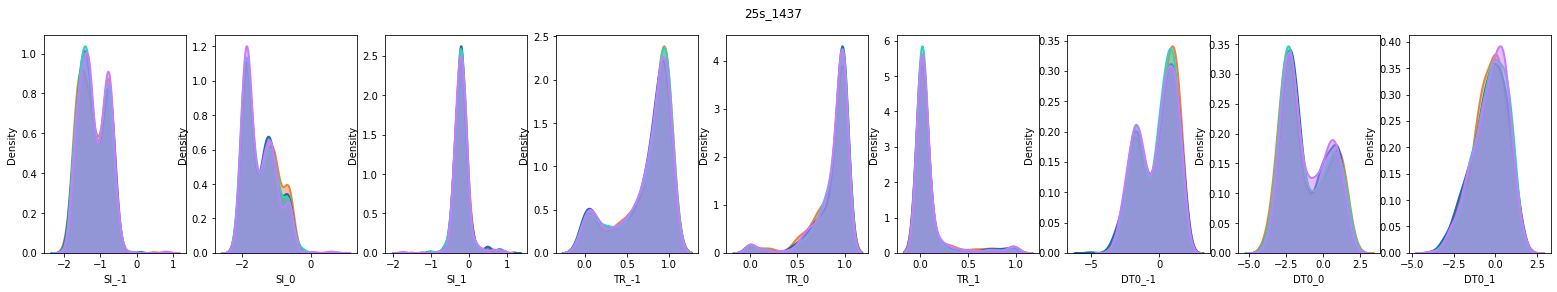

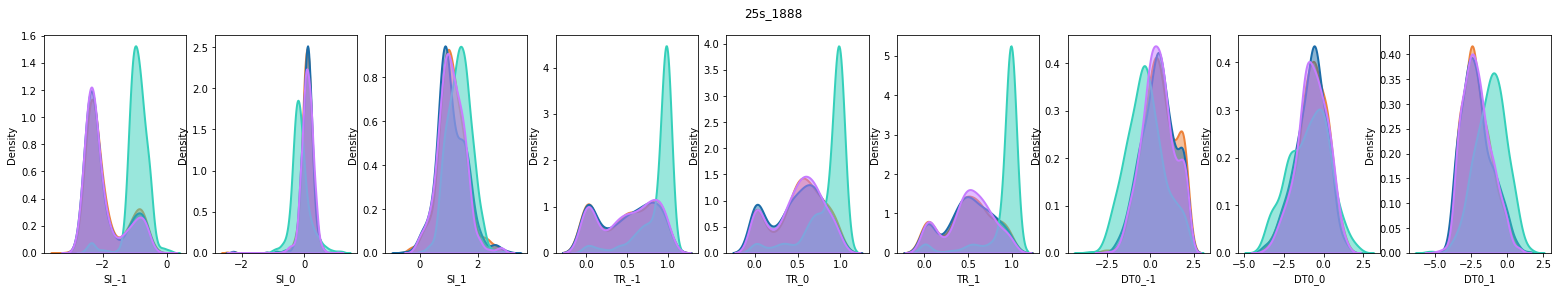

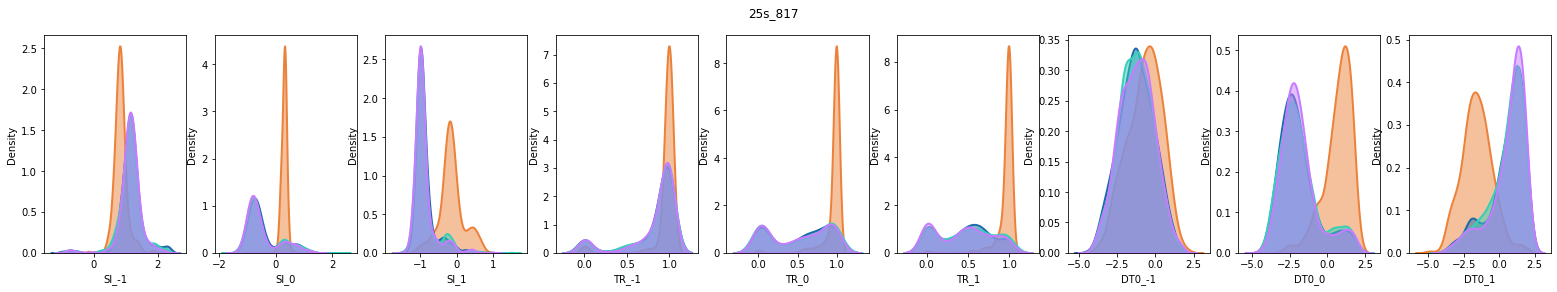

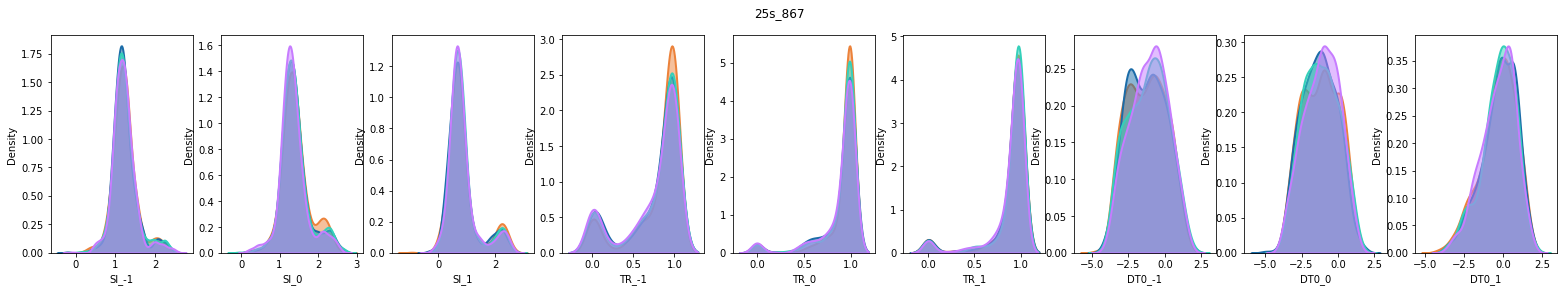

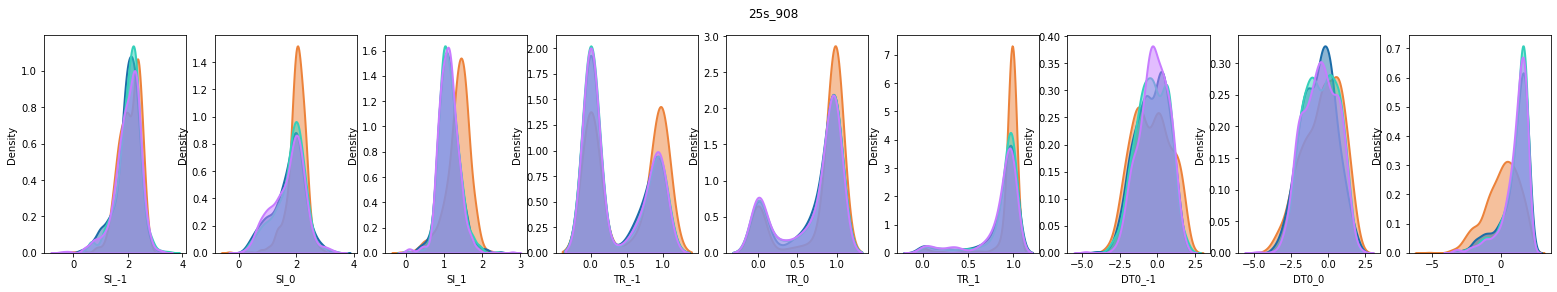

In [3]:
outdir = "results/rRNA.density_plots"
if not os.path.isdir(outdir): os.makedirs(outdir)
    
color_codes_wanted = list("cmyr")

# concatenate all pos and samples into one dataframe
dframes = []
for ri, (ref, pos) in enumerate(region2data.keys()): #regions): #[3]#; print(ref, pos, mt)
    mer, calls = region2data[(ref, pos)]
    for c, s in zip(calls, samples): 
        df = pd.DataFrame(c, columns=feature_names)
        df["Strain"] = s
        df["chr_pos"] = "%s_%s"%(ref, pos)
        dframes.append(df)
# read all tsv files
df = pd.concat(dframes).dropna().reset_index(); df.head()

# plot all features
cols = list(filter(lambda x: x.startswith(("SI", "TR", "DT0")), df.columns)); cols
for cp in df.chr_pos.unique():
    print(cp)
    # define color pallete
    if cp in chr_pos: enmax_palette = ["#f8766d", "#7cae00", "#00bfc4", "#c77cff"]    # pU
    elif cp in chr_pos2: enmax_palette = ["#ec823a", "#1b6ca8", "#35d0ba", "#c77cff"] # Nm
    get_color = lambda x: enmax_palette[color_codes_wanted.index(x)]
    fig, axes1 = plt.subplots(1, len(cols), figsize=(3*len(cols), 4))
    fig.suptitle(cp)
    axes1[0].set_ylabel("Density")
    for ax, col in zip(axes1, cols):
        for s, c in zip(samples, color_codes_wanted):
            sns.kdeplot(df[df["chr_pos"]==cp].loc[df["Strain"]==s][col], color=get_color(c), ax=ax, linewidth=2, shade=True, alpha=.5, legend=False)#, kernel="biw")
        ax.set_xlabel(col)
    fig.savefig(os.path.join(outdir, "%s.pdf"%cp))